## [ArtFacePoints: High-resolution Facial Landmark Detection in Paintings and Prints](https://github.com/asindel/ArtFacePoints)
- **연구 소개**
  - FaceOfArt와 유사한 목적의 연구(accepted at the VISART VI Workshop at the ECCV 2022)
- **테스트 목적**
  - 기존 연구 데이터세트 구축을 위해 FaceOfArt 를 사용했기에 카툰 도메인 비교를 위해 테스트를 진행
- **실행 방법** 
  - 1) ArtFacePoints 코드와 Pretrained Weights를 다운
  - 2) 데이터 경로 설정
  - 3) 실행

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/2023_LAB/ArtFacePoints

/content/drive/MyDrive/2023_LAB/ArtFacePoints


In [ ]:
# !git clone https://github.com/asindel/ArtFacePoints

Cloning into 'ArtFacePoints'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 3), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 815.26 KiB | 2.59 MiB/s, done.


## 명령어로 실행
```

    parser = argparse.ArgumentParser('facial landmark detection') 
    parser.add_argument('--root_dir', help='path to root',type=str, default='D:/Project/Code/FaceDetection/ArtFacePoints') #put your path here
    parser.add_argument('--data_dir', help='path to dataset root',type=str, default='D:/Project/Data/FaceDatabases/StyleArtFacesDataset/test') #put your path here
    parser.add_argument('--dataset_dir', help='path to dataset dir (can be subfolder)',type=str, default='D:/Project/Data/FaceDatabases/StyleArtFacesDataset/test/Paintings') #put your path here
    parser.add_argument('--model_dir', help='trained region model dir',type=str, default='D:/Project/Code/FaceDetection/ArtFacePoints/weights') #put your path here
    parser.add_argument('--model_epoch', type=str, default='best', help='epoch of trained region model')
    parser.add_argument('--load_checkpoint', type=bool, default=True, help='model_path is path to checkpoint (True) or path to state dict (False)')
    parser.add_argument('--out_dir', help='path to dataset dir',type=str, default='E:/FacialLandmarks/ArtDataset/test/ArtFacePoints') #put your path here
    parser.add_argument('--save_global_pred', action='store_true', default=False, help="Additionally save the global predictions of ArtFacePoints (first stage)")
    parser.add_argument('--scale', type=float, default=1, help='scaling factor for saving predictions e.g. 1 or 0.25')
    parser.add_argument('--patch_size', type=int, default=1024, help='input patch size')
    parser.add_argument('--global_patch_size', type=int, default=256, help='global network input patch size')
    parser.add_argument('--region_size', type=int, default=256, help='region network input patch size')
    parser.add_argument('--batch_size', type=int, default=2, help='batch size')
    parser.add_argument('--which_network', type=str, default='resnet_9blocks', help='unet or resnet_6blocks or resnet_9blocks')
    parser.add_argument('--up_type', type=str, default= 'bicubic', help='transposed conv or bicubic + conv') 
    parser.add_argument('--input_nc', type=int, default=3, help='network input channel')
    parser.add_argument('--output_nc', type=int, default=68, help='network output channel') 
    parser.add_argument('--upsampling_mode', type=str, default='bicubic', help='upsampling method for landmark refinement: bicubic, linear')
    parser.add_argument('--norm', type=str, default= 'batch', help='normalization layer: batch') 
    parser.add_argument('--init_type', type=str, default= 'normal', help='initialization of network: normal') 
    parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
    parser.add_argument('--no-cuda', action='store_true', default=False, help='disable CUDA training (please use CUDA_VISIBLE_DEVICES to select GPU)')
```

In [ ]:
# !python detect_facial_landmarks_ArtFacePoints.py -- root_dir /content/drive/MyDrive/2023_LAB/ArtFacePoints --data

## 코드로 실행

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 8 2021

@author: Aline Sindel
"""

import argparse
import os
import torch
import cv2

from test_dataset import ImageDataset
from network import ArtFacePoints
from data_utils import visualizeLandmarks, write_landmarks_as_pts_format, set_random_seeds, getRelPaths

In [4]:
def lanmark_detector_art(opt):

    set_random_seeds(0)
    
    opt.use_cuda = (not opt.no_cuda and torch.cuda.is_available())
    device = torch.device("cuda:0" if opt.use_cuda else "cpu")   
    
    test_dataset = ImageDataset(opt.dataset_dir, opt.patch_size)    
    len_test_set = len(test_dataset)    
    print("Test set contains {} images".format(len_test_set))    
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=opt.batch_size, shuffle=False, num_workers=0)

    facial_net = ArtFacePoints(opt, device)
    facial_net.load_weights(opt.model_dir, opt.model_epoch, opt.load_checkpoint)
    facial_net.eval()
  
    img_paths = test_dataset.image_filenames
    img_files = getRelPaths(img_paths, opt.data_dir)  

    print("Run ArtFacePoints and save predictions and visualizations to ", opt.out_dir)
    
    for i, images in enumerate(test_loader):        
          images = images.to(device)         
          
          with torch.no_grad():
              predictions, global_predictions, LR_images = facial_net(images)              
              
              # save predictions and landmark visualizations to disk
              B = images.size(0)
              for b in range(B):
                  LR_image = LR_images[b].unsqueeze(dim=0)
                  image = images[b].unsqueeze(dim=0)
                  global_prediction = global_predictions[b].unsqueeze(dim=0)
                  prediction = predictions[b].unsqueeze(dim=0)
                  
                  if opt.save_global_pred:
                      #visualize global facial landmark results
                      global_img_landmark_pred = visualizeLandmarks(LR_image, global_prediction, in_size=opt.region_size, line_thickness=1, point_radius=3)
                      global_img_landmark_pred = cv2.cvtColor(global_img_landmark_pred,cv2.COLOR_RGB2BGR)              
                      global_out_patchfile = os.path.join(opt.out_dir, "overlay_pred_global_landmarks", img_files[i*B+b])
                      out_subdirs,_ = os.path.split(global_out_patchfile)
                      if os.path.exists(out_subdirs)==False:
                          os.makedirs(out_subdirs)
                      cv2.imwrite(global_out_patchfile, global_img_landmark_pred)
                  
                  #visualize region facial network refinement results               
                  img_landmark_pred = visualizeLandmarks(image, prediction, in_size=opt.patch_size, line_thickness=5, point_radius=10)
                  img_landmark_pred = cv2.cvtColor(img_landmark_pred,cv2.COLOR_RGB2BGR)              
                  out_patchfile = os.path.join(opt.out_dir, "overlay_pred_landmarks", img_files[i*B+b])
                  out_subdirs,_ = os.path.split(out_patchfile)
                  if os.path.exists(out_subdirs)==False:
                      os.makedirs(out_subdirs)
                  cv2.imwrite(out_patchfile, img_landmark_pred)  
                  
                  if opt.save_global_pred:
                      #save global landmarks predictions (in .pts format)
                      np_global_prediction = (global_prediction.detach().cpu().numpy().squeeze(0) + 0.5)*opt.patch_size*opt.scale
                      #print(np_global_prediction)
                      out_global_pred_ptsfile = os.path.join(opt.out_dir, "pred_global_landmarks", os.path.splitext(img_files[i*B+b])[0]+".pts")
                      out_subdirs,_ = os.path.split(out_global_pred_ptsfile)
                      if os.path.exists(out_subdirs)==False:
                          os.makedirs(out_subdirs)
                      write_landmarks_as_pts_format(np_global_prediction, out_global_pred_ptsfile)
                  
                  #save ArtFacePoints landmarks predictions (in .pts format (as in menpo lib), note: 1 pixel offset will be added, since .pts format is using Matlab indexing)
                  np_prediction = (prediction.detach().cpu().numpy().squeeze(0) + 0.5)*opt.patch_size*opt.scale
                  out_pred_ptsfile = os.path.join(opt.out_dir, "pred_landmarks", os.path.splitext(img_files[i*B+b])[0]+".pts")
                  out_subdirs,_ = os.path.split(out_pred_ptsfile)
                  if os.path.exists(out_subdirs)==False:
                      os.makedirs(out_subdirs)                 
                  write_landmarks_as_pts_format(np_prediction, out_pred_ptsfile)
    
    print('Total number of test images: {}'.format(len(test_dataset)))

In [20]:
class Option():
  root_dir = '/content/drive/MyDrive/2023_LAB/ArtFacePoints'
  data_dir = '/content/drive/MyDrive/2023_LAB/ArtFacePoints/test'
  dataset_dir = '/content/drive/MyDrive/2023_LAB/ArtFacePoints/test/webtoon'
  model_dir = '/content/drive/MyDrive/2023_LAB/ArtFacePoints/weights'
  model_epoch = 'best'
  load_checkpoint = True
  out_dir = '/content/drive/MyDrive/2023_LAB/ArtFacePoints/outputs'
  save_global_pred = False
  scale = 1 # 0.25
  patch_size = 1024
  global_patch_size = 256
  region_size = 256
  batch_size = 2
  which_network = 'resnet_9blocks'#  help='unet or resnet_6blocks or resnet_9blocks'
  up_type = 'bicubic' # help='transposed conv or bicubic + conv'
  input_nc = 3
  output_nc = 68
  upsampling_mode = 'bicubic' # help='upsampling method for landmark refinement: bicubic, linear'
  norm = 'batch'
  init_type = 'normal'
  no_dropout = True
  no_cuda = False

opt = Option()
lanmark_detector_art(Option())

Test set contains 25 images
initialization method [normal]
initialization method [normal]
initialization method [normal]
initialization method [normal]
Run ArtFacePoints and save predictions and visualizations to  /content/drive/MyDrive/2023_LAB/ArtFacePoints/outputs
Total number of test images: 25


24



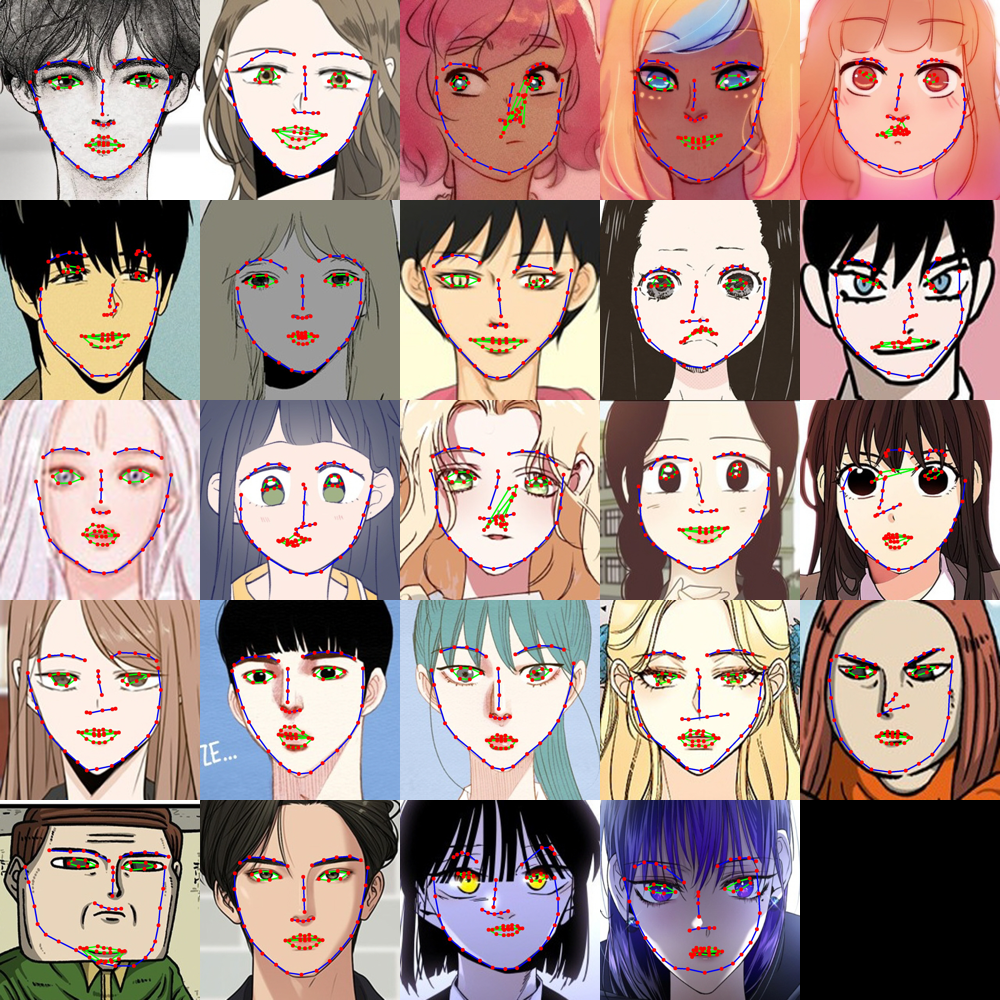

In [28]:
from PIL import Image
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = Image.open(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    print(len(images))
    return images

def make_image_grid(images):
    # 이미지 크기를 조정합니다.
    images_resized = [img.resize((200, 200)) for img in images]
    # 이미지를 5x5 표로 재배열합니다.
    grid = Image.new('RGB', (1000, 1000))
    for i in range(5):
        for j in range(5):
            try:
              grid.paste(images_resized[i*5+j], (j*200, i*200))
            except:
              print()
    return grid

folder_path = opt.out_dir + '/overlay_pred_landmarks/webtoon'
images = load_images_from_folder(folder_path)
grid_image = make_image_grid(images)
grid_image.show()

## 결과
- 눈,코,입 등 형태 비율이 일반적인 사람의 형태와 크게 다른 경우 랜드마크가 제대로 감지되지 않음(특히 눈)

## Results
- 
Landmarks are not detected properly if the proportions of the eyes, nose, mouth, etc. are significantly different from those of a normal person.